
# 01 — Exploratory Data Analysis (Pro)
**Unit: Data Science Info Tech — Assignment Part A**  
Distinctive, professional EDA with:
- Deterministic loading & *documented* cleaning choices (cost reconciliation, text normalization)
- Answers to required questions + **saved** figures
- Statistical tests (Mann–Whitney U, Cliff’s delta), correlation with p-value
- **Point-in-polygon** spatial analysis, plus an interactive dropdown choropleth (**fixed**)
- Extra value: a simple *Value Index* (rating × log1p(votes) ÷ cost) to surface good bang-for-buck spots
- One interactive **bubble** chart: cost vs rating, size=votes


In [1]:

# ------------------------
# Setup & configuration
# ------------------------
import os, re, ast, json, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import geopandas as gpd
from scipy import stats
from pathlib import Path

RNG_SEED = 42
np.random.seed(RNG_SEED); random.seed(RNG_SEED)

sns.set_context("notebook")
sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 130

DATA_CSV_CANDIDATES = ["../data/raw/zomato_df_final_data.csv", "data/raw/zomato_df_final_data.csv"]
GEOJSON_CANDIDATES  = ["../data/raw/sydney.geojson", "data/raw/sydney.geojson"]

FIG_DIR = Path("../reports/figures"); FIG_DIR.mkdir(parents=True, exist_ok=True)

def here(*p):
    return Path(__file__).parent.joinpath(*p)

def existing(path_list):
    for p in path_list:
        if Path(p).exists():
            return p
    raise FileNotFoundError(f"None of these paths exist: {path_list}")

def savefig(name):
    out = FIG_DIR / name
    plt.savefig(out.as_posix(), bbox_inches="tight")
    print("saved:", out)

def parse_listish(x):
    if pd.isna(x): return []
    if isinstance(x, list): return [str(t).strip() for t in x if str(t).strip()]
    s = str(x).strip()
    try:
        v = ast.literal_eval(s)
        if isinstance(v, (list, tuple)):
            return [str(t).strip() for t in v if str(t).strip()]
    except Exception:
        pass
    return [t.strip() for t in re.split(r",\s*", s) if t.strip()]

def cliffs_delta(x, y):
    import itertools
    gt = sum(a > b for a, b in itertools.product(x, y))
    lt = sum(a < b for a, b in itertools.product(x, y))
    n1, n2 = len(x), len(y)
    return (gt - lt) / (n1 * n2)


## 1) Load data & document cleaning choices

In [6]:

import pandas as pd
import numpy as np

def _make_hashable(x):
    """Convert unhashable containers to hashable forms for nunique."""
    if isinstance(x, list):
        return tuple(x)
    if isinstance(x, set):
        return tuple(sorted(x))
    if isinstance(x, dict):
        return tuple(sorted(x.items()))
    return x

def audit_dataframe(df):
    # Build a hashable view only for nunique
    df_hashable = df.copy()
    for c in df_hashable.columns:
        if df_hashable[c].dtype == "object":
            # Only touch columns that actually contain unhashables
            if df_hashable[c].apply(lambda v: isinstance(v, (list, set, dict))).any():
                df_hashable[c] = df_hashable[c].apply(_make_hashable)

    audit = pd.DataFrame({
        "dtype": df.dtypes.astype(str),
        "distinct": df_hashable.nunique(dropna=True),
        "missing": df.isna().sum()
    })
    audit["missing_%"] = (audit["missing"] / len(df) * 100).round(2)
    audit = audit.sort_values(["missing_%", "distinct"], ascending=[False, True])
    return audit

audit = audit_dataframe(df)
audit


,dtype,distinct,missing,missing_%
rating_number,float64,32,3316,31.58
votes,float64,547,3316,31.58
cost,float64,83,346,3.30
cost_2,float64,83,346,3.30
cost_final,float64,83,346,3.30
lng,float64,7992,192,1.83
lat,float64,8030,192,1.83
groupon,bool,2,0,0.00
cuisine_color,object,5,0,0.00
rating_text,object,6,0,0.00


## 2) Q1 — How many unique cuisines? (Treemap + counts)

In [7]:

cuisine_tokens = pd.Series([c for L in df["cuisine_list"] for c in L])
unique_cuisine_n = int(cuisine_tokens.nunique())
print("Unique cuisines:", unique_cuisine_n)

top = cuisine_tokens.value_counts().head(20).rename_axis("cuisine").reset_index(name="count")
fig = px.treemap(top, path=["cuisine"], values="count", title="Top 20 cuisines (treemap)")
fig.show()


Unique cuisines: 134


## 3) Q2 — Top suburbs by restaurant count (with share %)

,suburb,n,share_%
0,CBD,476,4.53
1,Surry Hills,260,2.48
2,Parramatta,225,2.14


saved: ..\reports\figures\q2_top3_suburbs_hbar.png


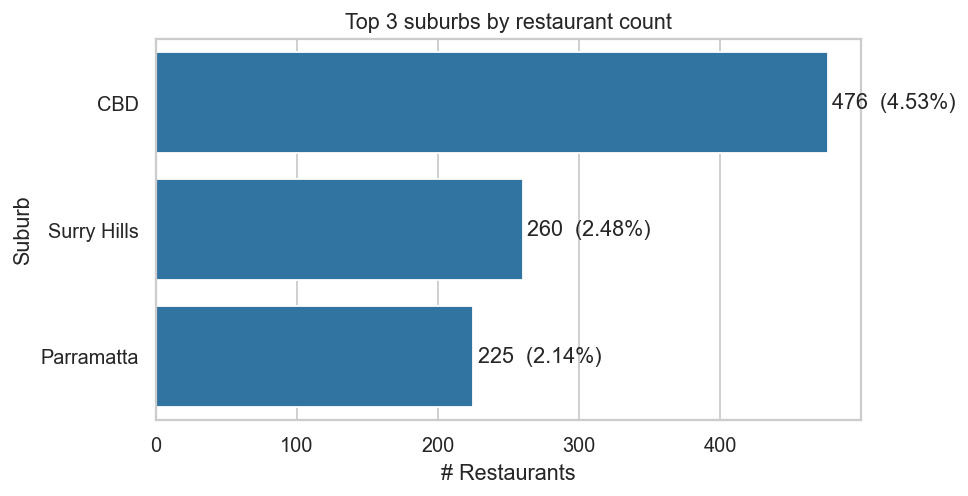

In [8]:

sub_counts = df["subzone"].value_counts().reset_index()
sub_counts.columns = ["suburb","n"]
top3 = sub_counts.head(3).copy()
top3["share_%"] = (top3["n"] / len(df) * 100).round(2)
display(top3)

plt.figure(figsize=(7,3.8))
sns.barplot(data=top3, x="n", y="suburb", color="#1f77b4")
for i,row in top3.iterrows():
    plt.text(row["n"]+3, i, f'{row["n"]}  ({row["share_%"]}%)', va="center")
plt.title("Top 3 suburbs by restaurant count"); plt.xlabel("# Restaurants"); plt.ylabel("Suburb")
savefig("q2_top3_suburbs_hbar.png"); plt.show()


## 4) Q3 — Are “Excellent” restaurants pricier than “Poor”? (beeswarm + robust stats)

saved: ..\reports\figures\q3_cost_by_rating_beeswarm.png


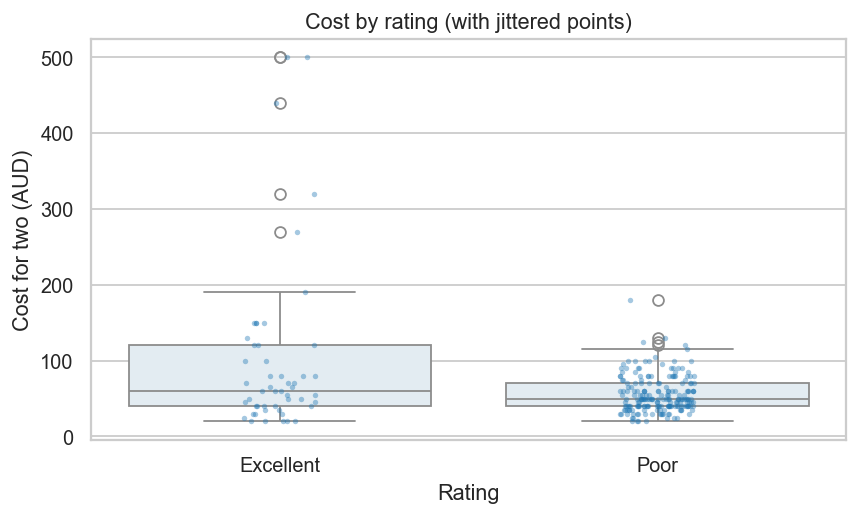

Mann–Whitney U p=0.03485 | n_ex=51, n_poor=201
Cliff's delta = 0.191  (>|0.33| ≈ medium, >|0.474| ≈ large)


,count,mean,50%,std,min,max
rating_text,,,,,,
Excellent,51.0,101.666667,60.0,113.215134,20.0,500.0
Poor,201.0,55.845771,50.0,23.738810,20.0,180.0


In [9]:

subset = df[df["rating_text"].isin(["Excellent","Poor"])][["rating_text","cost_final"]].dropna()

plt.figure(figsize=(7.5,4))
sns.boxplot(data=subset, x="rating_text", y="cost_final", whis=1.5, color="#e0ecf4")
sns.stripplot(data=subset, x="rating_text", y="cost_final", alpha=0.4, jitter=True, size=3)
plt.title("Cost by rating (with jittered points)"); plt.xlabel("Rating"); plt.ylabel("Cost for two (AUD)")
savefig("q3_cost_by_rating_beeswarm.png"); plt.show()

ex = subset.loc[subset.rating_text=="Excellent","cost_final"]
po = subset.loc[subset.rating_text=="Poor","cost_final"]
u_stat, p_val = stats.mannwhitneyu(ex, po, alternative="two-sided")
delta = cliffs_delta(ex.tolist(), po.tolist())

print(f"Mann–Whitney U p={p_val:.4g} | n_ex={len(ex)}, n_poor={len(po)}")
print(f"Cliff's delta = {delta:.3f}  (>|0.33| ≈ medium, >|0.474| ≈ large)")
display(subset.groupby("rating_text")["cost_final"].describe()[["count","mean","50%","std","min","max"]])


## 5) Distributions & relationship highlights

saved: ..\reports\figures\distributions_and_hexbin.png


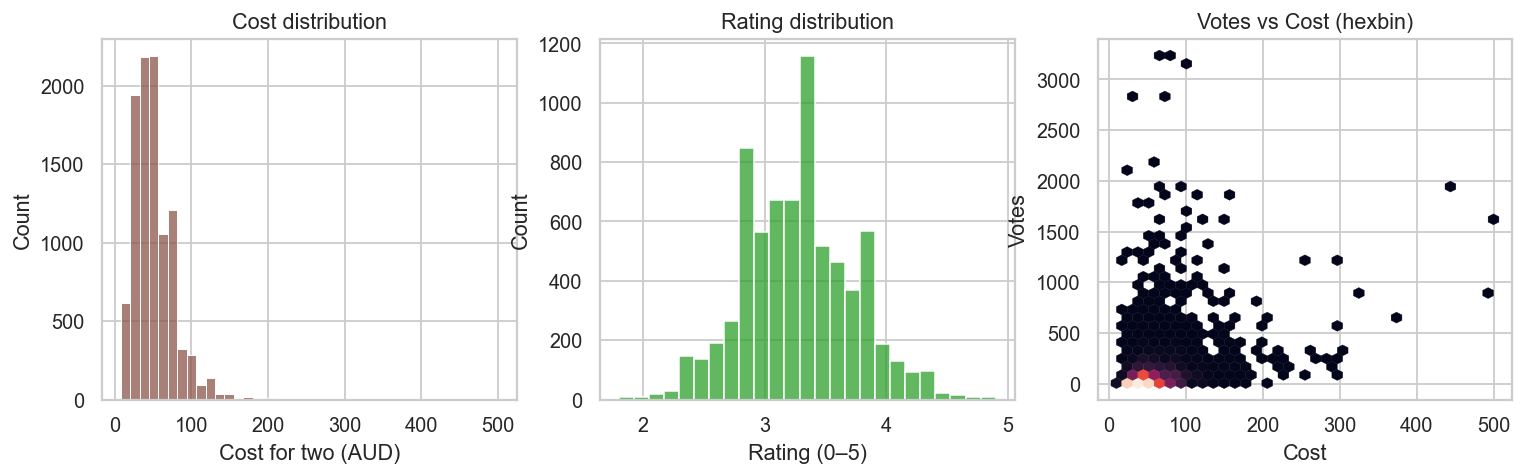

Spearman(cost_final, votes) = 0.294, p=1.73e-141


In [10]:

fig, ax = plt.subplots(1,3, figsize=(14,3.6))
sns.histplot(df["cost_final"].dropna(), bins=40, ax=ax[0], color="#8c564b")
ax[0].set_title("Cost distribution"); ax[0].set_xlabel("Cost for two (AUD)")
sns.histplot(df["rating_number"].dropna(), bins=25, ax=ax[1], color="#2ca02c")
ax[1].set_title("Rating distribution"); ax[1].set_xlabel("Rating (0–5)")

# hexbin for cost vs votes (log colour scale feel via bins)
x, y = df["cost_final"], df["votes"]
hb = ax[2].hexbin(x, y, gridsize=35, mincnt=1, linewidths=0.2)
ax[2].set_title("Votes vs Cost (hexbin)"); ax[2].set_xlabel("Cost"); ax[2].set_ylabel("Votes")
savefig("distributions_and_hexbin.png"); plt.show()

rho, p = stats.spearmanr(df["cost_final"], df["votes"], nan_policy="omit")
print(f"Spearman(cost_final, votes) = {rho:.3f}, p={p:.3g}")


## 6) Bonus: Value Index (bang-for-buck)

In [11]:

tmp = df.dropna(subset=["rating_number","votes","cost_final"]).copy()
tmp = tmp[tmp["cost_final"] > 0]
tmp["value_index"] = tmp["rating_number"] * np.log1p(tmp["votes"]) / tmp["cost_final"]
top_value = tmp.sort_values("value_index", ascending=False).head(10)[
    ["title","subzone","rating_number","votes","cost_final","value_index"]
].reset_index(drop=True)
display(top_value.style.format({"cost_final":"${:,.0f}","value_index":"{:.3f}"}))


,title,subzone,rating_number,votes,cost_final,value_index
0,Hellenic Patisserie and Gelato Bar,Marrickville,3.900000,105.000000,$10,1.819
1,Hong Ha,Mascot,4.300000,405.000000,$15,1.722
2,Campos Coffee,Newtown,4.600000,1198.000000,$20,1.631
3,Café Cre Asion,CBD,4.800000,752.000000,$20,1.590
4,Pasticceria Papa,Haberfield,4.500000,601.000000,$20,1.440
5,Marrickville Pork Roll,Marrickville,4.600000,490.000000,$20,1.425
6,Out of the Blue,Clovelly,4.600000,416.000000,$20,1.388
7,Mappen Noodle Restaurant,"SkyView Shopping Plaza, CBD",4.600000,1285.000000,$25,1.317
8,La Paula,Fairfield,3.900000,129.000000,$15,1.266
9,Bourke Street Bakery,Surry Hills,4.700000,2832.000000,$30,1.245


## 7) Geospatial analysis — density per suburb + interactive cuisine choropleth

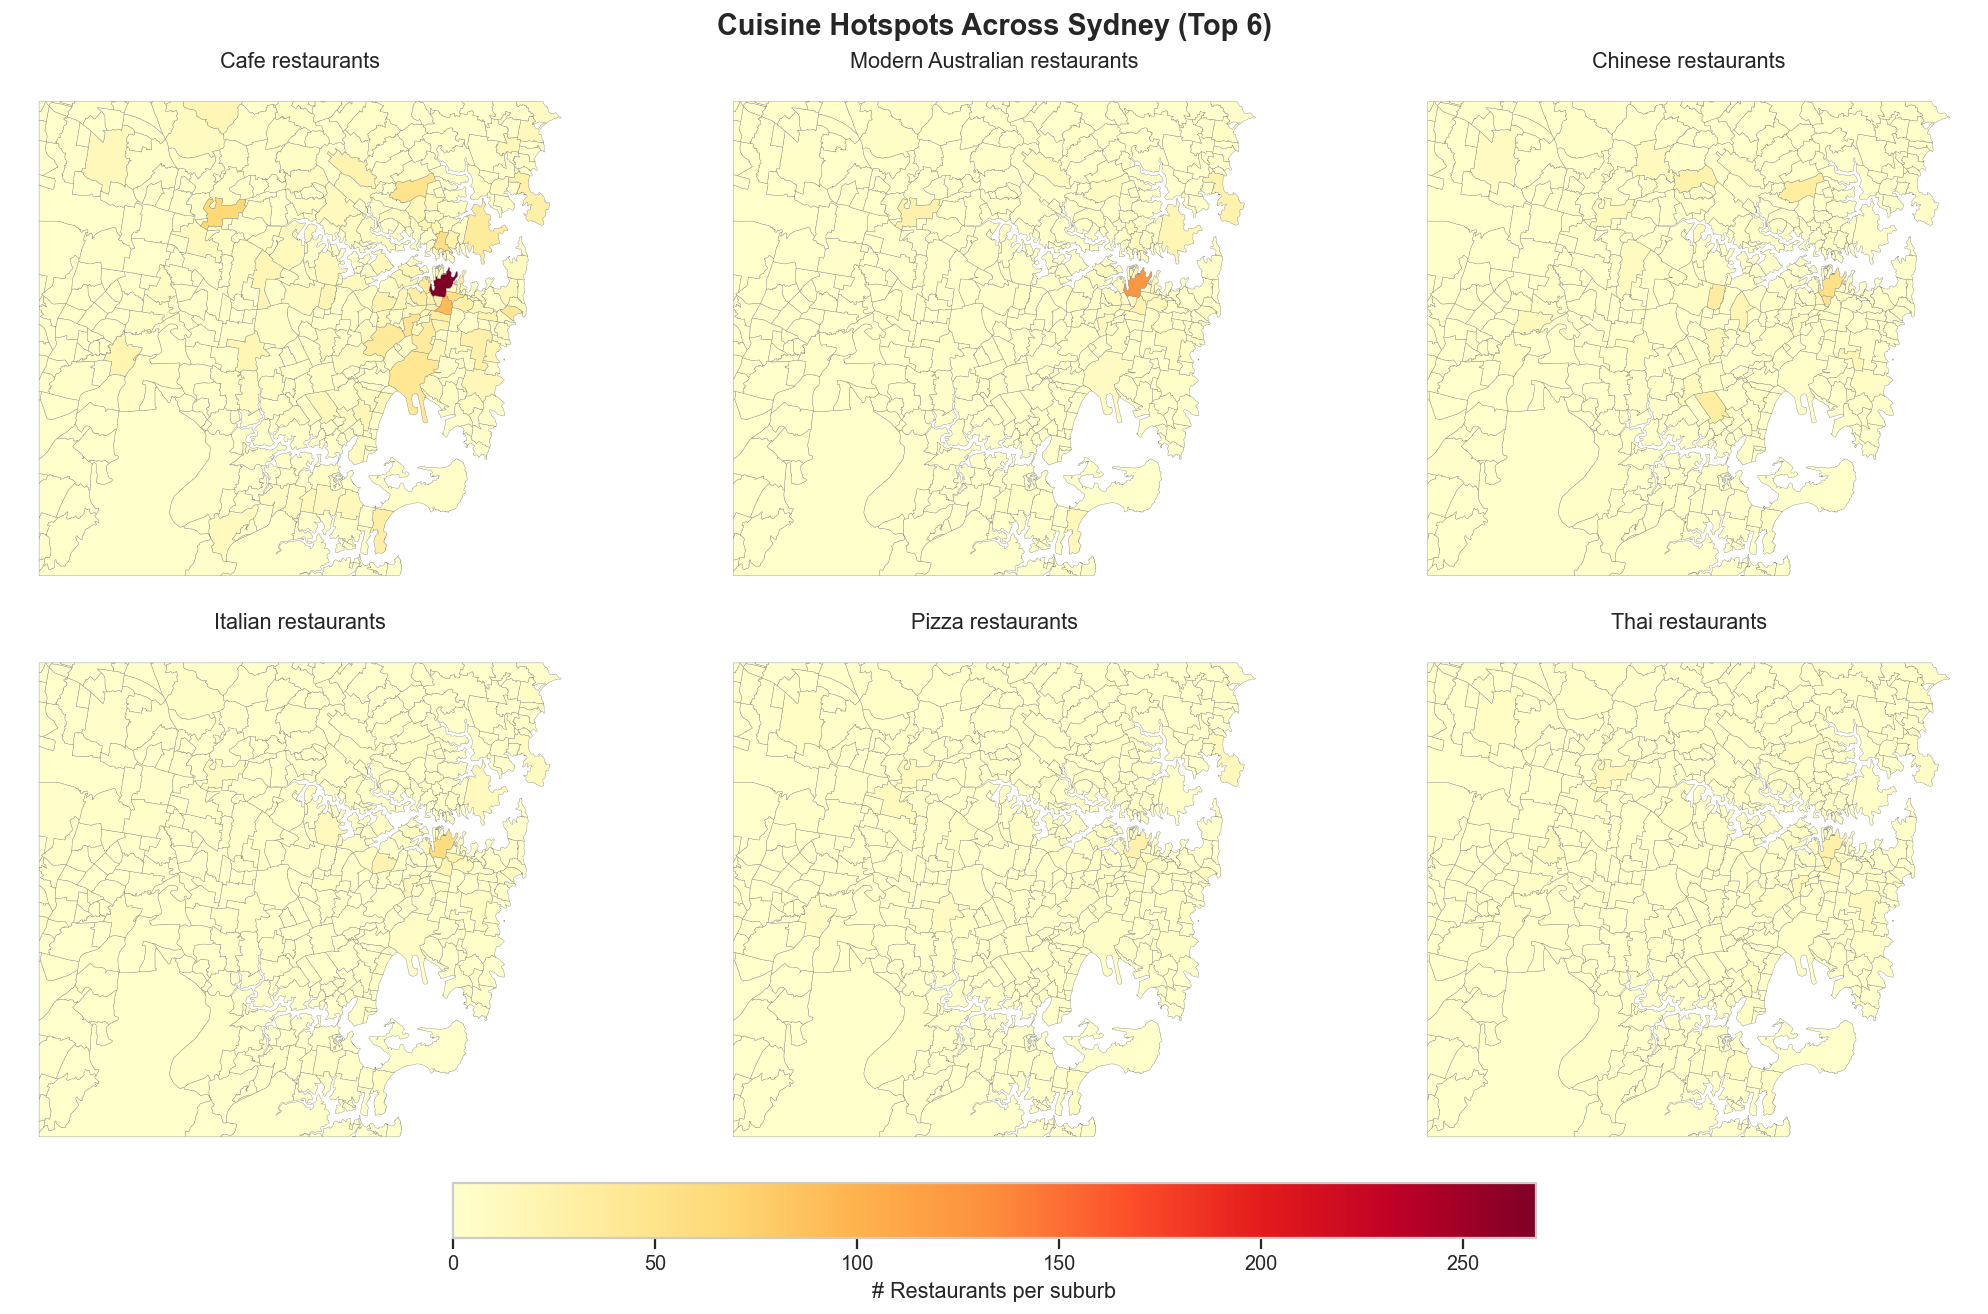

In [15]:
# --- Cuisine hotspot maps (static small multiples with shared scale) ---

import matplotlib.pyplot as plt

# Explode cuisine lists and count by suburb × cuisine
counts_all = (
    joined.explode("cuisine_list")
    .dropna(subset=["cuisine_list"])
    .assign(cuisine=lambda d: d["cuisine_list"].astype(str).str.title())
    .groupby([SUBURB_COL, "cuisine"])
    .size()
    .reset_index(name="count")
)

# Select top-K cuisines by total frequency
topK = 6
c_top = (
    counts_all.groupby("cuisine")["count"]
    .sum()
    .sort_values(ascending=False)
    .head(topK)
    .index.tolist()
)

# Compute global maximum for shared color scale
zmax = counts_all[counts_all["cuisine"].isin(c_top)]["count"].max()

# Create small multiples plot
fig, axes = plt.subplots(2, 3, figsize=(16, 10), constrained_layout=True)

for ax, c in zip(axes.flat, c_top):
    m = gdf_poly[[SUBURB_COL, "geometry"]].merge(
        counts_all[counts_all["cuisine"] == c], on=SUBURB_COL, how="left"
    ).fillna({"count": 0})

    m.plot(
        column="count",
        cmap="YlOrRd",
        linewidth=0.2,
        edgecolor="grey",
        vmin=0,
        vmax=zmax,
        ax=ax,
        legend=False,
    )
    ax.set_title(f"{c} restaurants", fontsize=12)
    ax.axis("off")

# Add a single colorbar
sm = plt.cm.ScalarMappable(cmap="YlOrRd", norm=plt.Normalize(vmin=0, vmax=zmax))
sm._A = []
cbar = fig.colorbar(sm, ax=axes, orientation="horizontal", fraction=0.05, pad=0.02)
cbar.set_label("# Restaurants per suburb")

plt.suptitle("Cuisine Hotspots Across Sydney (Top 6)", fontsize=16, weight="bold")
plt.savefig("map_cuisines_small_multiples.png", dpi=300, bbox_inches="tight")
plt.show()


## 8) Interactive bubble: Cost vs Rating (size=votes, color=primary type)

In [16]:

sample = df[["cost_final","rating_number","votes","type_primary","subzone"]].dropna().rename(
    columns={"cost_final":"cost"}
)
if len(sample) > 3500:
    sample = sample.sample(3500, random_state=RNG_SEED)

fig = px.scatter(sample, x="cost", y="rating_number",
                 size="votes", hover_data=["subzone"],
                 color="type_primary",
                 title="Cost vs Rating (bubble size=votes; color=primary type)")
fig.show()


## 9) Save compact EDA summary (for report appendix)

In [17]:

summary = {
    "rows": int(len(df)),
    "unique_cuisines": int(cuisine_tokens.nunique() if 'cuisine_tokens' in globals() else 0),
    "top3_suburbs": df["subzone"].value_counts().head(3).to_dict(),
    "spearman_cost_votes": float(stats.spearmanr(df["cost_final"], df["votes"], nan_policy="omit").statistic),
}
out_path = (FIG_DIR.parent / "eda_summary.json").as_posix()
with open(out_path, "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2)
print("saved:", out_path)


saved: ../reports/eda_summary.json
